## 网页爬取+多模态内容识别+RAG构建本地知识库+中文大语言模型

1. 网页爬取和解析，生成本地元数据  [OrcaStudio介绍](http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/README),
2. 分析元数据中的文本和图片，放入 vector store
3. 基于 vector store + qwen 模型的问答功能




## 网页爬取和解析，生成本地元数据


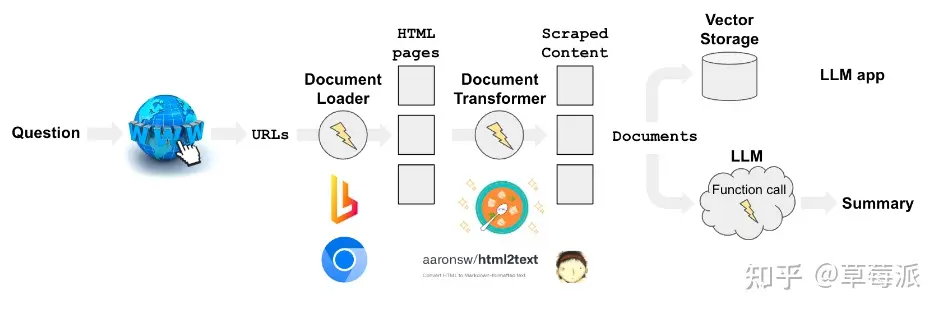

Question->URLs: 通过URLs来search网页，可以是一个URL，也可以是多个URL

Document Loader->HTML pages: 用langchain提供的文档加载器获取目标网页的html，如AsyncHtmlLoader, AsyncChromiumLoader等

Document Transformer->Scraped Content: 用langchain提供的文档转换器工具解析HTML中的需要抓取的信息，如HTML2Tex或Beautiful Soup，形成格式化的文本

In [94]:
# !pip install langchain playwright beautifulsoup4

`接下来安装playwright主体，这一步非常重要，否则playwright无法初始化`

In [95]:
# !python -m playwright install

### 获取html

导入AsyncChromiumLoader文档加载器和BeautifulSoupTransformer文档转换器：

In [96]:
from langchain.document_loaders import AsyncChromiumLoader
from langchain.document_transformers import BeautifulSoupTransformer

import nest_asyncio
nest_asyncio.apply()

用AsyncChromiumLoader初始化一个文档加载器对象，AsyncChromiumLoader使用Playwright来启动一个Chromium实例，该实例可以处理复杂的网页交互，默认是无头模式。

无头模式意味着浏览器在没有图形用户界面的情况下运行，通常用于网页抓取。

In [97]:
urls = ["http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/README",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/about",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/industry",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/product",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/usecase",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/guide",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/prequire",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/installation",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/datalink_install",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/gui",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/workflow",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/intro/coloboration",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/collaborate",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/why",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/can",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/cannot",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/pixar",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/imaging",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/lighting",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/material",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/format",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/camera",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/settings",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/USD/MayaOrca",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/brief",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/asset_processor",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/pathtracer",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/pbr_basic",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/pbr_textures",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/pbr_guide",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/udim",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/dynamicbone",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/trackview_intro",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/trackview_guide",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/feature",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/engine/ros2",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/datalink/brief",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/datalink/guide",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/connector/brief",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/connector/devguide",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/connector/AEC",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/connector/robot",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/connector/art",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/connector/education",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/store/brief",
        "http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/store/upload"]

loader = AsyncChromiumLoader(urls)

import copy

html = loader.load()
print(html)
html_bak = copy.deepcopy(html)

[Document(page_content='<!DOCTYPE html><html lang="en" style="--siteFont: Source Sans Pro,Helvetica Neue,Arial,sans-serif; --defaultTheme: dark; --codeFontFamily: Roboto Mono, Monaco, courier, monospace; --bodyFontSize: 15px; --accent: #42b983; --toogleBackground: #091a28; --background: #ffffff; --textColor: #34495e; --codeTextColor: #525252; --codeBackgroundColor: #f8f8f8; --borderColor: rgba(0, 0, 0, 0.07); --blockQuoteColor: #858585; --highlightColor: #e96900; --sidebarSublink: #505d6b; --codeTypeColor: #091a28; --coverBackground: linear-gradient(to left bottom, hsl(118, 100%, 85%) 0%,hsl(181, 100%, 85%) 100%); --toogleImage: url(https://cdn.jsdelivr.net/npm/docsify-darklight-theme@latest/icons/moon.svg); color-scheme: light;"><head>\n  <meta charset="UTF-8">\n  <title>OrcaStudio使用文档</title>\n  <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n  <meta name="description" content="Description">\n  <meta name="viewport" content="width=device-width, initial-scale=1.0, mini

`加载html`

### 解析HTML

从HTML内容中提取文本内容

In [111]:
#初始化一个BeautifulSoupTransformer对象
bs_transformer = BeautifulSoupTransformer()

#提取html里tag为span的内容为text文档
docs_transformed = bs_transformer.transform_documents(html,tags_to_extract=["span", "p"])
html = copy.deepcopy(html_bak)

#打印这个文档
print(docs_transformed)

[Document(page_content='松应科技 (http://www.orca3d.cn/) 知乎-松应科技 (https://www.zhihu.com/org/song-ying-ke-ji-cgaas) OrcaStudio产品概述 使用流程 (#/intro/workflow)  注意这里是相对路径 USD使用介绍 OrcaEngine Orca Datalink Orca Connector Orca AI Orca AssetsStore . OrcaStudio（预览版本） 使用指南 OrcaStudio 协同，智能的3D内容创作平台 请按照以下步骤了解松应科技Orca系列产品： Copy to clipboard Error Copied 下一篇', metadata={'source': 'http://71.136.100.40:3000/?wework_cfm_code=MoL9rcXqCEX2sOXsQF8QRLWWz2NKlLNTXHflPKSOu22ZGPZv%2B4%2BI86KrzytAQ%2F%2FePVNxWUutHYlKRjEP20YhSI0%3D#/README'}), Document(page_content='松应科技 (http://www.orca3d.cn/) 知乎-松应科技 (https://www.zhihu.com/org/song-ying-ke-ji-cgaas) OrcaStudio产品概述 使用流程 (#/intro/workflow)  注意这里是相对路径 USD使用介绍 OrcaEngine Orca Datalink Orca Connector Orca AI Orca AssetsStore . 公司介绍： 北京松应科技有限公司成立于2021年底。公司坐落于北京市海淀区。公司核心团队来自华为、海思、网易、腾讯、AutoDesk、清华、浙大等知名企业及高校，在相关领域均具有10年以上经验，成功负责过多个ToB产品完整商业化落地。2022年5月，公司获得红杉资本、云启资本数百万美元种子轮投资。 松应科技自主研发中国首个3D数字智能协同平台，基于云3D引擎架构连接多类DCC数字生产软件、AIGC模型、行业领先工业软件等，让设计师/创作者/工程师/上下游供应商等能够实时协同创作，并提供实

In [112]:
#取page_content前500个元素
for doc in docs_transformed:
    print(doc.page_content[0:5000])

松应科技 (http://www.orca3d.cn/) 知乎-松应科技 (https://www.zhihu.com/org/song-ying-ke-ji-cgaas) OrcaStudio产品概述 使用流程 (#/intro/workflow)  注意这里是相对路径 USD使用介绍 OrcaEngine Orca Datalink Orca Connector Orca AI Orca AssetsStore . OrcaStudio（预览版本） 使用指南 OrcaStudio 协同，智能的3D内容创作平台 请按照以下步骤了解松应科技Orca系列产品： Copy to clipboard Error Copied 下一篇
松应科技 (http://www.orca3d.cn/) 知乎-松应科技 (https://www.zhihu.com/org/song-ying-ke-ji-cgaas) OrcaStudio产品概述 使用流程 (#/intro/workflow)  注意这里是相对路径 USD使用介绍 OrcaEngine Orca Datalink Orca Connector Orca AI Orca AssetsStore . 公司介绍： 北京松应科技有限公司成立于2021年底。公司坐落于北京市海淀区。公司核心团队来自华为、海思、网易、腾讯、AutoDesk、清华、浙大等知名企业及高校，在相关领域均具有10年以上经验，成功负责过多个ToB产品完整商业化落地。2022年5月，公司获得红杉资本、云启资本数百万美元种子轮投资。 松应科技自主研发中国首个3D数字智能协同平台，基于云3D引擎架构连接多类DCC数字生产软件、AIGC模型、行业领先工业软件等，让设计师/创作者/工程师/上下游供应商等能够实时协同创作，并提供实时3D渲染，助力高质量3D内容低成本、高效率、高质量生产。愿与行业合作伙伴一起，在工业高保真设计、工业数字孪生与仿真等领域积极探索更多应用，助力中国数字经济发展。 上一篇 下一篇
松应科技 (http://www.orca3d.cn/) 知乎-松应科技 (https://www.zhihu.com/org/song-ying-ke-ji-cgaas) OrcaStudio产品概述 使用流程 (#/intro/workflow)  注意这里是相对